# Time Series in IOT (Internet of Things)
## IOT Time Series Forescating / Regression

## About Dataset
### Context
You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the traffic patterns of the four junctions of the city. Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days. This is important to take into account for your forecasting.

### Content
To predict traffic patterns in each of these four junctions for the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import polars as pl
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [2]:
data = pd.read_csv("train_ML_IOT.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## Exploratory Data Analysis

In [3]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping ID column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

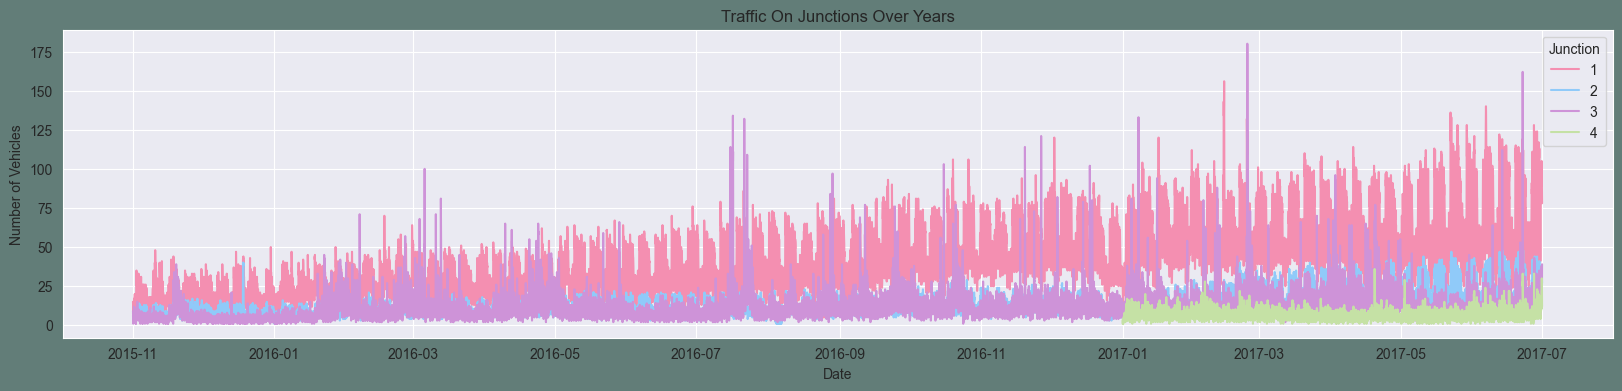

In [4]:
df=data.copy() 
colors = ["#F48FB1", "#90CAF9", "#CE93D8", "#C5E1A5"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.
It can be seen here that the first junction is visibly having an upward trend.
The data for the fourth junction is sparse starting only after 2017.    

## Feature Engineering

I am creating a few new features out of DateTime. Namely:

Year, Month, Date in the given month, Days of week, Hour

In [5]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["DayNo"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,DayNo,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


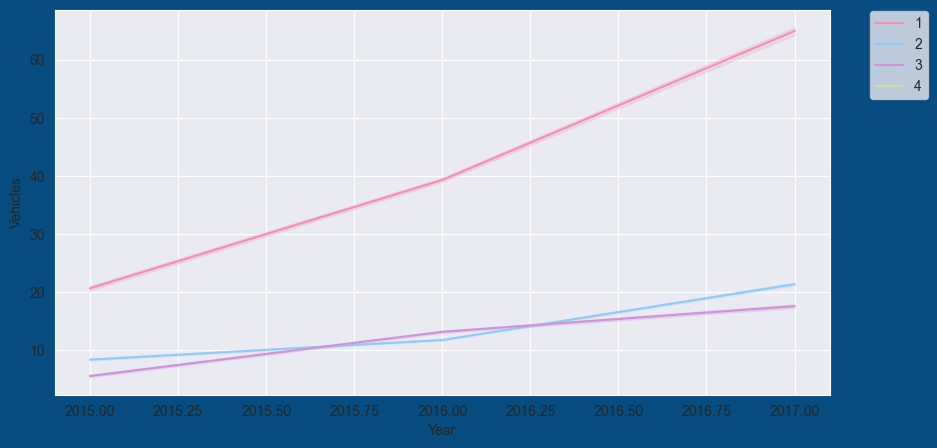

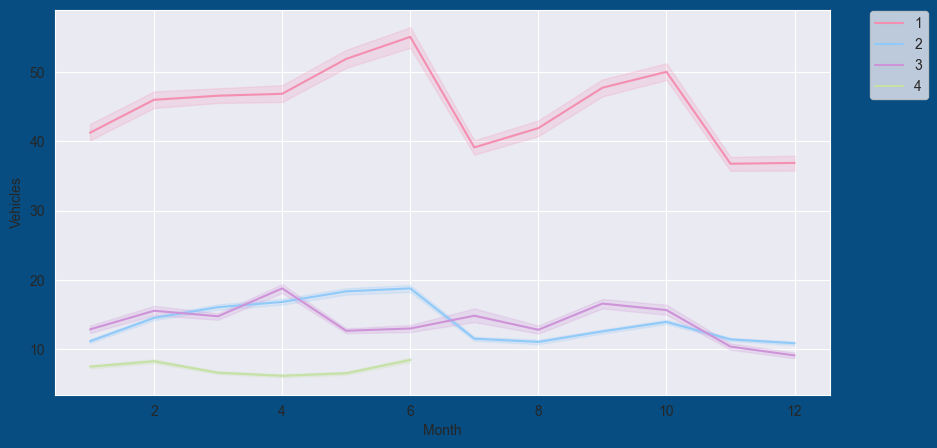

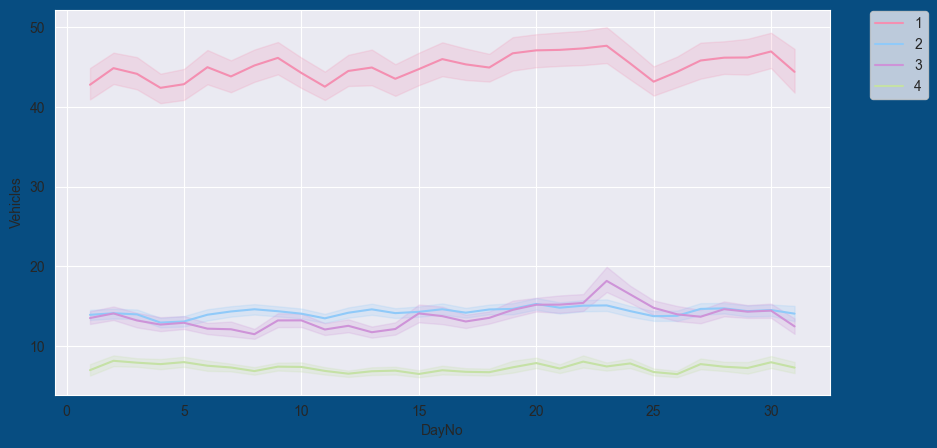

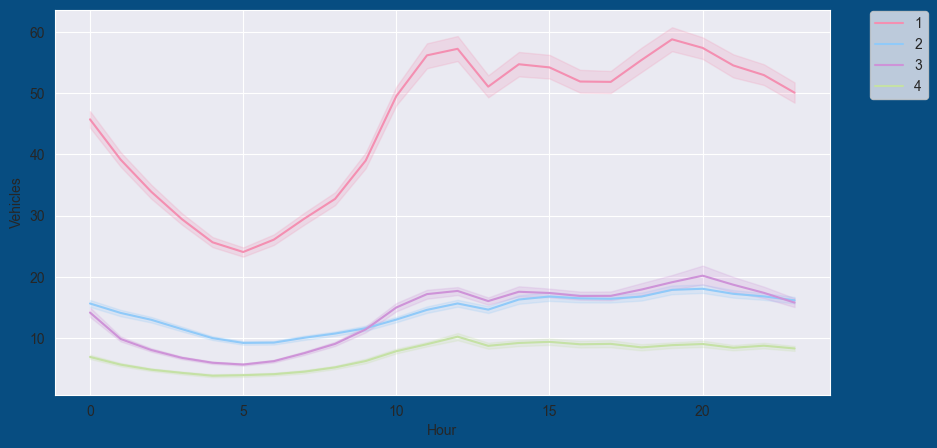

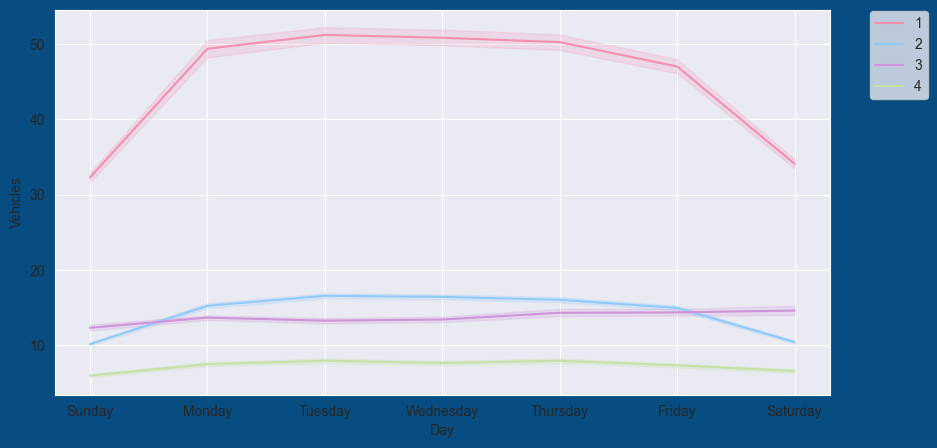

In [6]:
new_features = [ "Year","Month", "DayNo", "Hour", "Day"]  # Plotting new feature

for i in new_features:
    plt.figure(figsize=(10,5),facecolor="#074d81")
    ax=sns.lineplot(x=df[i], y="Vehicles", data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

From the above plot following things can be concluded:

Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

I can see that there is an density in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

Monthly, throughout all the dates there is a good consistency in data.

For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

Text(0.5, 0, 'Date')

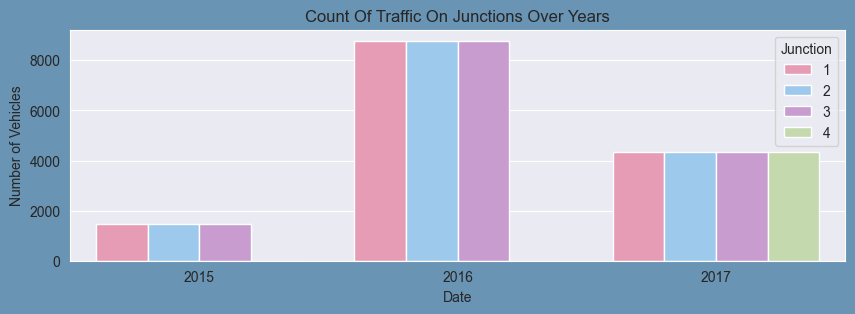

In [9]:
plt.figure(figsize=(10,3,),facecolor="#6a94b3")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 ie till the 7th month.

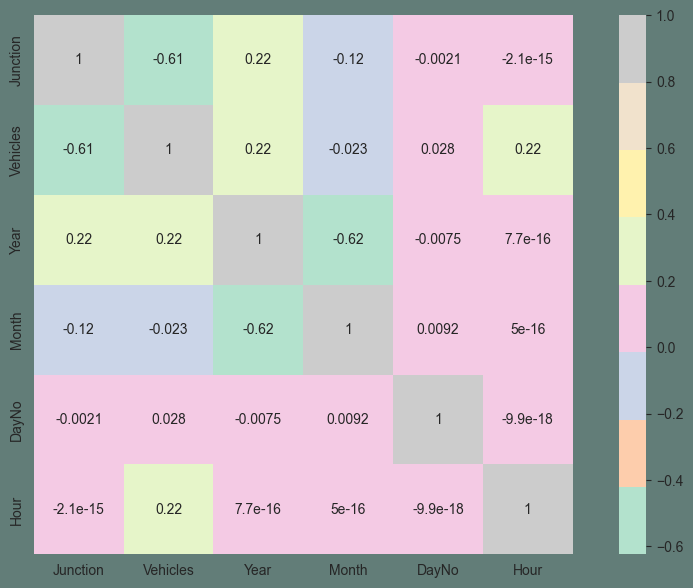

In [15]:
numeric_columns = df.select_dtypes(include=[np.number])

corrmat = numeric_columns.corr()

plt.subplots(figsize=(12, 7), facecolor="#627D78")
sns.heatmap(corrmat, cmap="Pastel2", annot=True, square=True)
plt.show()

Heatmap about data attributes

The value closer to 1 or -1 is best correlation to each other.
As close as to -1, that pair of attribute is more negative correlation.
As close as to 1, that pair of attribute is more positive correlation.
As close as to 0, that pair of attribute is not correlating to each other.

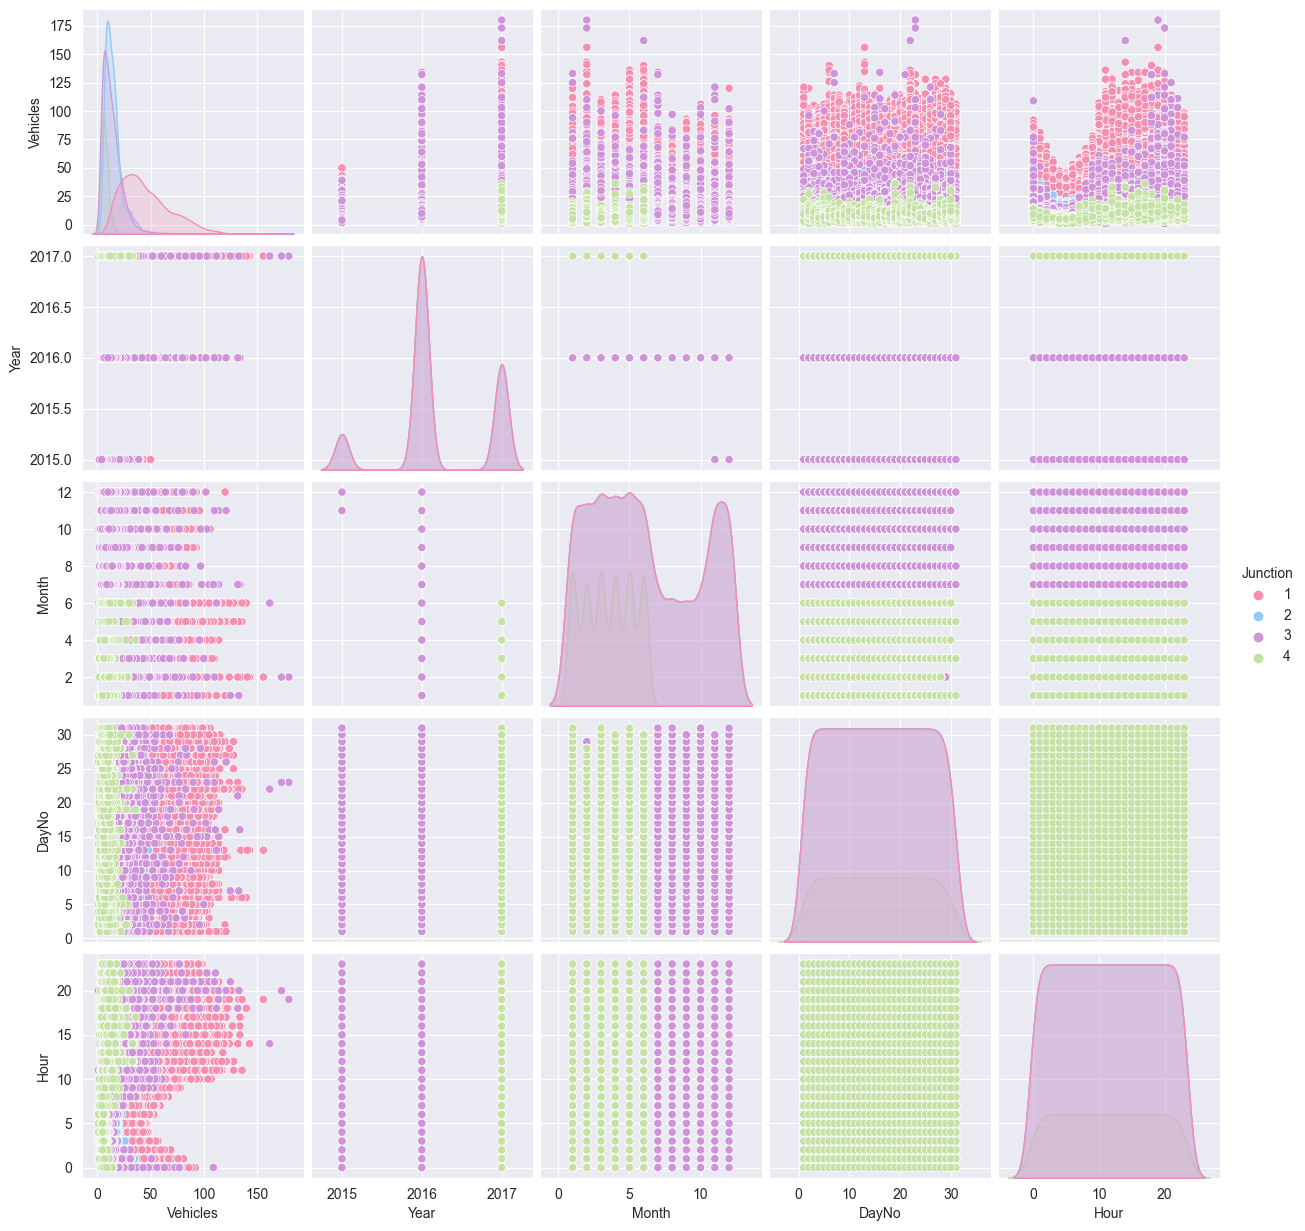

In [110]:
sns.pairplot(data=df, hue= "Junction", palette=colors)

Results of EDA:

The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
The yearly trend for Junctions one, two and three have different slopes.
Junction number one has a more strong weekly seasonality in comparison to the other junctions. In other words, it was seen that Junction 1 experienced more vehicle traffic on certain days of the week or that there was more variation on these days.

 I think that junctions must be transformed as per their individual needs.

## Data Preprocessing and Transformation

Creating different frames for each Junction and plotting them
Transforming the series and plotting them
Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series (The main purpose of the ADF test is to determine whether a time series is stationary. A stationary time series refers to a series in which its statistical properties remain constant over time and do not show a trend or periodic pattern. A stationary time series makes statistical analyzes more reliable.)
Creating test and train sets

In [16]:
# I used the pivot method to create the junction category tables.
df_junctions = data.pivot(columns="Junction", index="DateTime")  # Junction 1,2,3,4 columns
df_junctions

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

In [17]:
df_junctions.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [20]:
# I created a new dataframe for each junction.
df_junction_1 = df_junctions[[('Vehicles', 1)]] 
df_junction_2 = df_junctions[[('Vehicles', 2)]]
df_junction_3 = df_junctions[[('Vehicles', 3)]]
df_junction_4 = df_junctions[[('Vehicles', 4)]]
df_junction_4 = df_junction_4.dropna() # I dropped null values because there was limited data on Junction 4 for only a few months


list_df_junctions = [df_junction_1, df_junction_2, df_junction_3, df_junction_4]
for i in list_df_junctions:  # I removed the level one (level 1) column labels of a multi-level dataframe.
    i.columns= i.columns.droplevel(level=1)
print(df_junction_1.head())

                     Vehicles
DateTime                     
2015-11-01 00:00:00      15.0
2015-11-01 01:00:00      13.0
2015-11-01 02:00:00      10.0
2015-11-01 03:00:00       7.0
2015-11-01 04:00:00       9.0


#### Outlier Detection

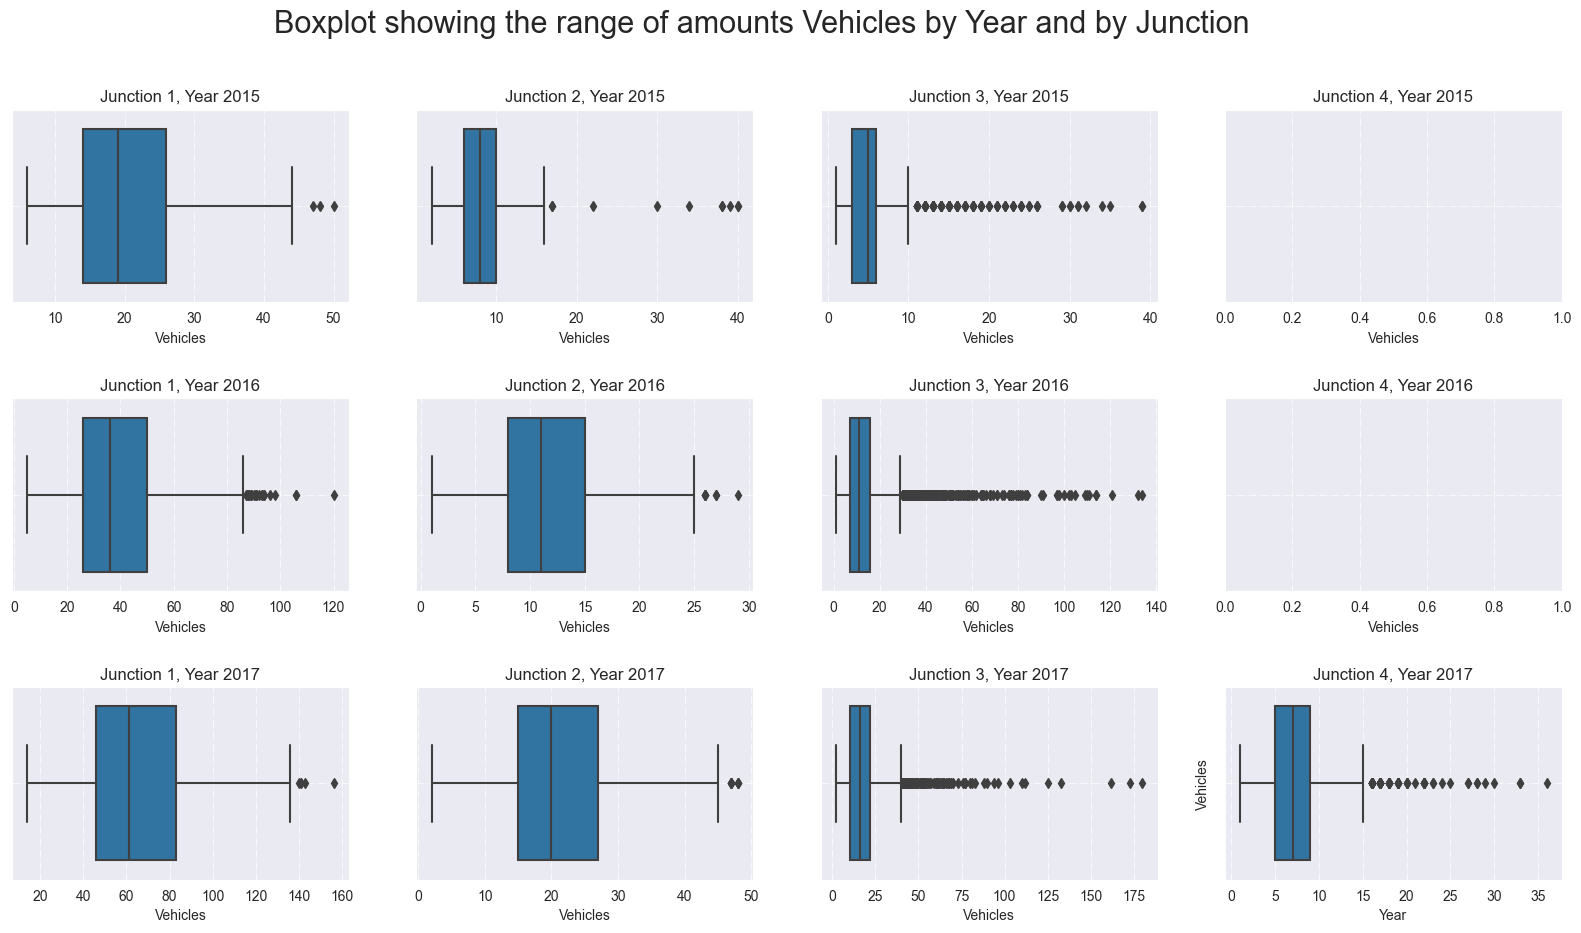

In [21]:
f, axis = plt.subplots(3, 4, figsize=(20, 10))

for i, year in zip(range(3), range(2015, 2018)):
  for j, junction in zip(range(4), range(1, 5)):
    sns.boxplot(x=df[(df["Junction"] == junction) & (df["Year"] == year)]['Vehicles'], ax=axis[i, j])
    axis[i, j].grid(True, alpha=0.75, ls='-.')


junction_names = ['Junction 1', 'Junction 2', 'Junction 3', 'Junction 4']
year = 2015
for i in range(3):
  for j in range(4):
    axis[i, j].set_title(f'{junction_names[j]}, Year {year + i}')


plt.subplots_adjust(hspace=0.5)  # Add this line to increase the space between subplots

plt.xlabel('Year')
plt.ylabel('Vehicles')
f.suptitle('Boxplot showing the range of amounts Vehicles by Year and by Junction', fontsize=22)
plt.show()

In each subplot, a boxplot is plotted visualizing the distribution of the "Vehicles" variable for a particular year and intersection combination

In boxplot, we can see a lot of outliers (those which is the dot)

In [39]:
def plot_outlier_detection(j, idx, rmeans, upper, lower):
    plt.figure(figsize=(14, 4)) 
    plt.plot(j)
    plt.plot(upper, color = 'blue')
    plt.plot(lower, color = 'blue')
    plt.plot(rmeans, color = 'red')
    plt.xlabel("Date")
    plt.ylabel("Vehicles")
    plt.scatter(j.index[idx], j[idx], color = 'yellow', zorder=10)
    plt.show()

plt.plot(rmeans, color='red'): This line is used to plot the moving average of the time series (rmeans) in red color. It visually represents the moving average.

plt.plot(upper, color='orange') and plt.plot(lower, color='orange'): These two lines plot the upper and lower bounds in orange color. These bounds represent the threshold values for outliers. upper represents the upper bounds, and lower represents the lower bounds.

plt.xlabel("Date") and plt.ylabel("Vehicles"): These lines set the axis labels for the graph. The X-axis is labeled as "Date," and the Y-axis is labeled as "Vehicles."

plt.scatter(j.index[idx], j[idx], color='purple', zorder=10): This line marks the detected outliers in purple color. The idx array marks the time points where outliers are found. The zorder parameter ensures that the outliers appear in front of other drawings.

In [43]:
def outlier_detection_kurtosis(junction, std_param = 3, window_length = 720):
    
    rmeans = junction.rolling(window_length, min_periods=1).median()
    rstd = junction.rolling(window_length, min_periods=1).std()
    rstd_lower = junction[junction<rmeans].rolling(window_length ,min_periods=1).std()
    
    kurtosis = j.kurt()
    
    upper = rmeans+std_param*rstd*np.exp(0.045*kurtosis)
    lower = rmeans - (5 * rstd_lower)    
    idx1 = (j>upper)
    idx2 = (j<lower)
    
    idx = idx1 | idx2
    
    return j, idx, rmeans, upper, lower

The code is used to detect outliers in a given hourly time series. The logic and mathematics of the code are as follows:

Firstly, moving averages and standard deviations are calculated for the time series. rmeans represents the median value of the time series within a specific window size (window_length). rstd represents the standard deviation within the same window size. rstd_lower calculates the standard deviation of data points that are lower than the rmeans value.

The kurtosis (flatness) value of the time series is calculated and assigned to the variable 'kurt.' Kurtosis describes the shape of a dataset by focusing on the frequency of peaks and troughs in the data distribution.

Upper and lower bounds are calculated using the moving averages (rmeans). 'upper' represents the upper bound, and 'lower' represents the lower bound. These bounds will be used for detecting outliers.

Outliers are defined as data points that are either greater than the upper bound or less than the lower bound. 'idx1' identifies data points greater than the upper bound, and 'idx2' identifies data points less than the lower bound.

Finally, by combining the results of 'idx1' and 'idx2,' the code creates the 'idx' array that contains all outlier data points.

This code detects outliers in the given hourly time series using moving statistics and kurtosis. Outliers are defined as data points outside specific bounds.

rolling_mean = time_series.rolling(window=5, min_periods=3).mean()
In this example, a moving average window is calculated with 'window' set to 5 data points and 'min_periods' set to 3 data points. This means that there should be a minimum of 3 data points inside the window for calculations. If there are 3 or more data points within the window, the calculation is performed; otherwise, it returns NaN (Not-a-Number) values.

In [44]:
all_junctions = [df_junction_1, df_junction_2, df_junction_3, df_junction_4]
for i,j in enumerate(all_junctions):
    all_junctions[i] = j.Vehicles
    all_junctions[i].index = j.index

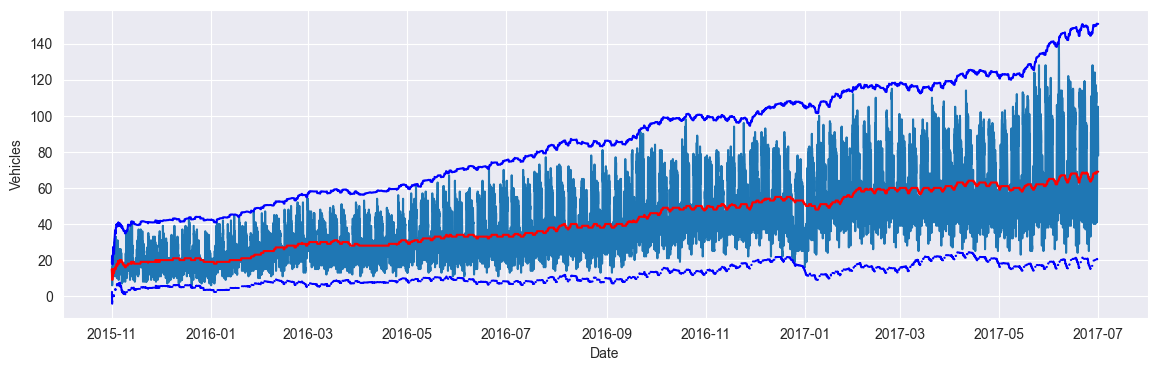

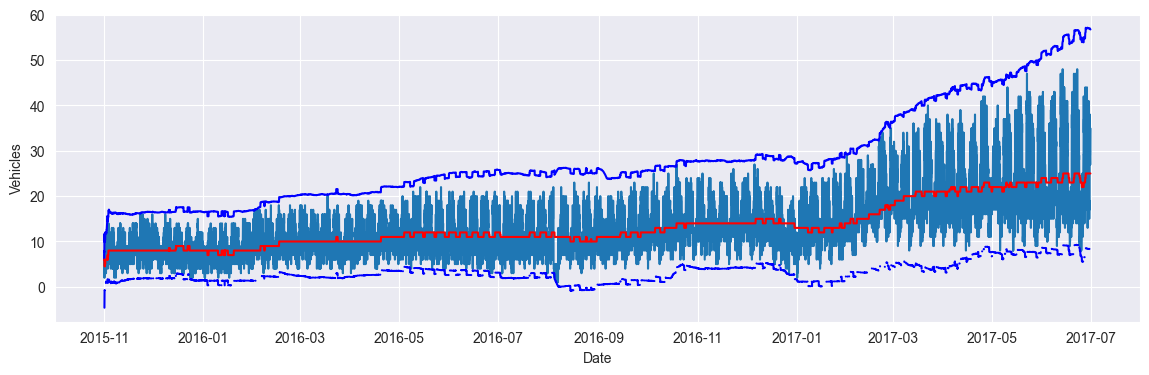

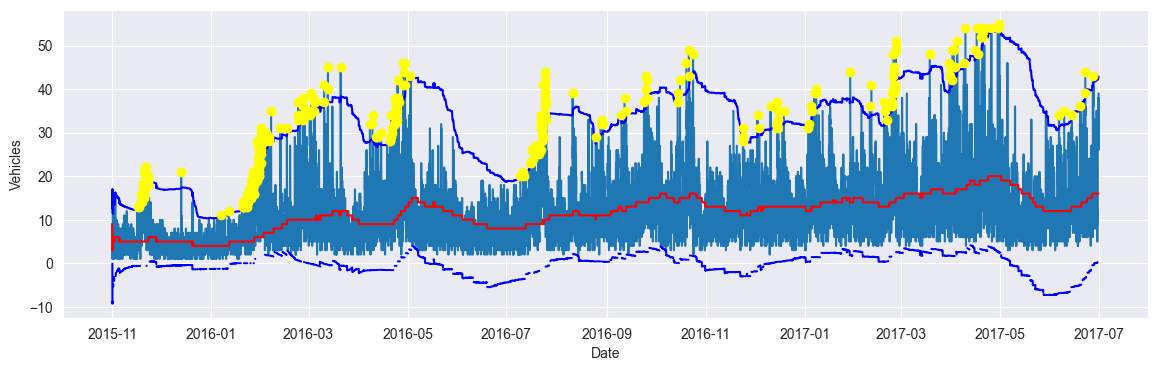

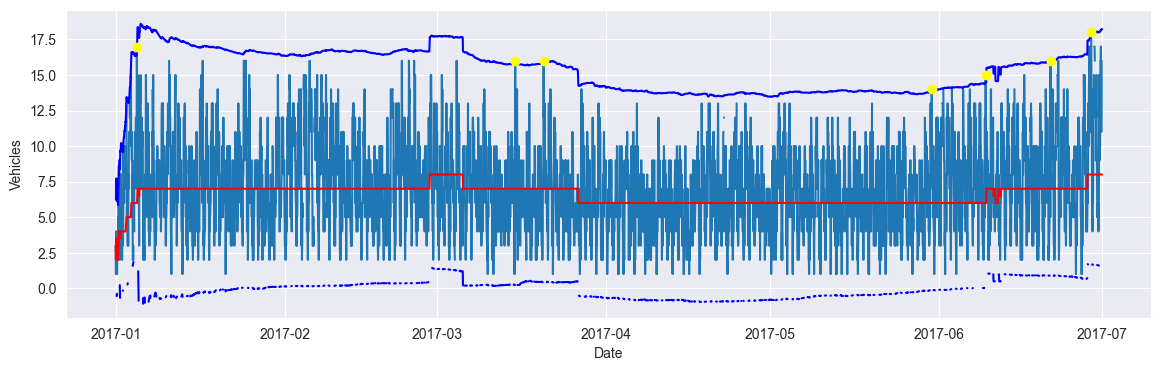

In [45]:
for j in all_junctions:
    j, idx, rmeans, upper, lower = outlier_detection_kurtosis(j)
    plot_outlier_detection(j, idx, rmeans, upper, lower)
    j[idx] = np.nan

In [46]:
df_junction_1['Vehicles'].isnull().sum()

6

In [30]:
df_junction_1

,Vehicles
DateTime,
2015-11-01 00:00:00,15.0
2015-11-01 01:00:00,13.0
2015-11-01 02:00:00,10.0
2015-11-01 03:00:00,7.0
2015-11-01 04:00:00,9.0
...,...
2017-06-30 19:00:00,105.0
2017-06-30 20:00:00,96.0
2017-06-30 21:00:00,90.0


In [31]:
df_junction_1 = df_junction_1.interpolate(method="ffill")
df_junction_2 = df_junction_2.interpolate(method="ffill")
df_junction_3 = df_junction_3.interpolate(method="ffill")
df_junction_4 = df_junction_4.interpolate(method="ffill")

In [32]:
df_junction_1['Vehicles'].isnull().sum()

0

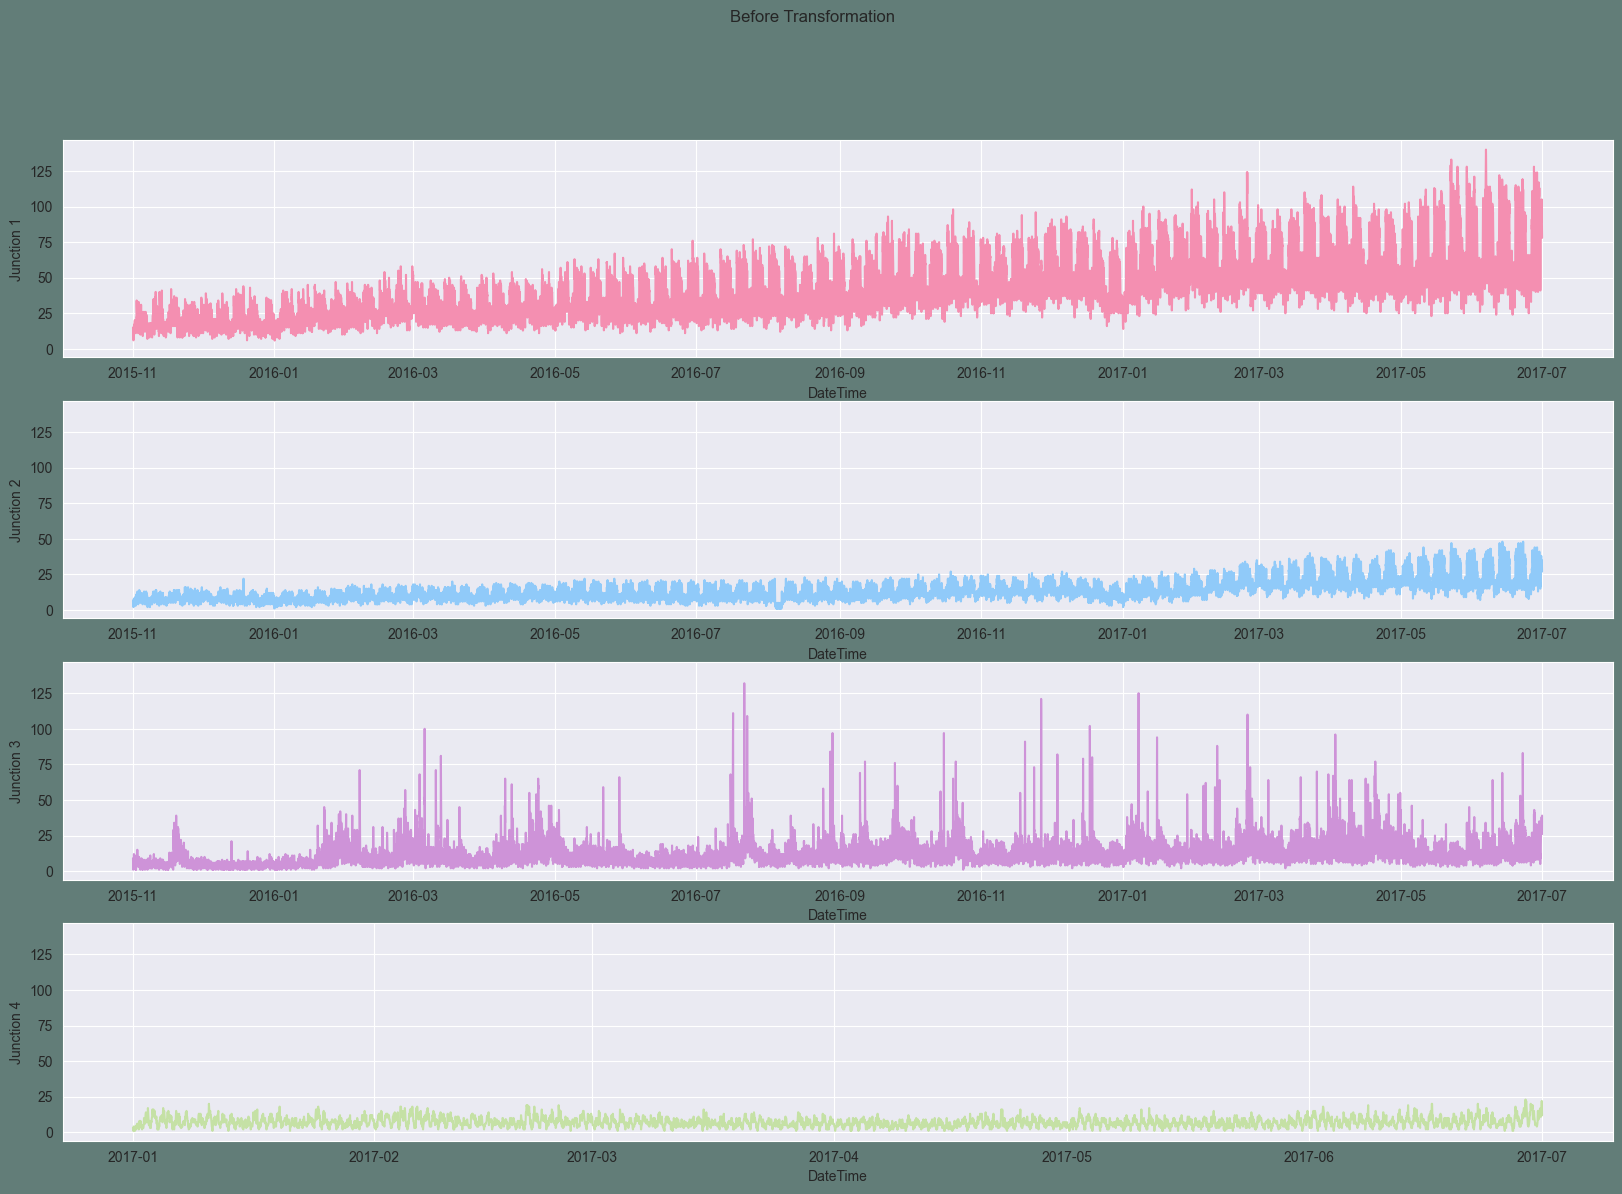

In [123]:
def sub_plots(df_1, df_2, df_3, df_4, title, start_date=None, end_date=None):
    fig, axes = plt.subplots(4, 1, figsize=(20, 13), facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    
    if start_date and end_date:
        df_1 = df_1[start_date:end_date]
        df_2 = df_2[start_date:end_date]
        df_3 = df_3[start_date:end_date]
        df_4 = df_4[start_date:end_date]

    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=colors[0])
    axes[0].set(ylabel="Junction 1")
    
    pl_2 = sns.lineplot(ax=axes[1], data=df_2, color=colors[1])
    axes[1].set(ylabel="Junction 2")
   
    pl_3 = sns.lineplot(ax=axes[2], data=df_3, color=colors[2])
    axes[2].set(ylabel="Junction 3")
    
    pl_4 = sns.lineplot(ax=axes[3], data=df_4, color=colors[3])
    axes[3].set(ylabel="Junction 4")

sub_plots(df_junction_1.Vehicles, df_junction_2.Vehicles, df_junction_3.Vehicles, df_junction_4.Vehicles, "Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, I saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

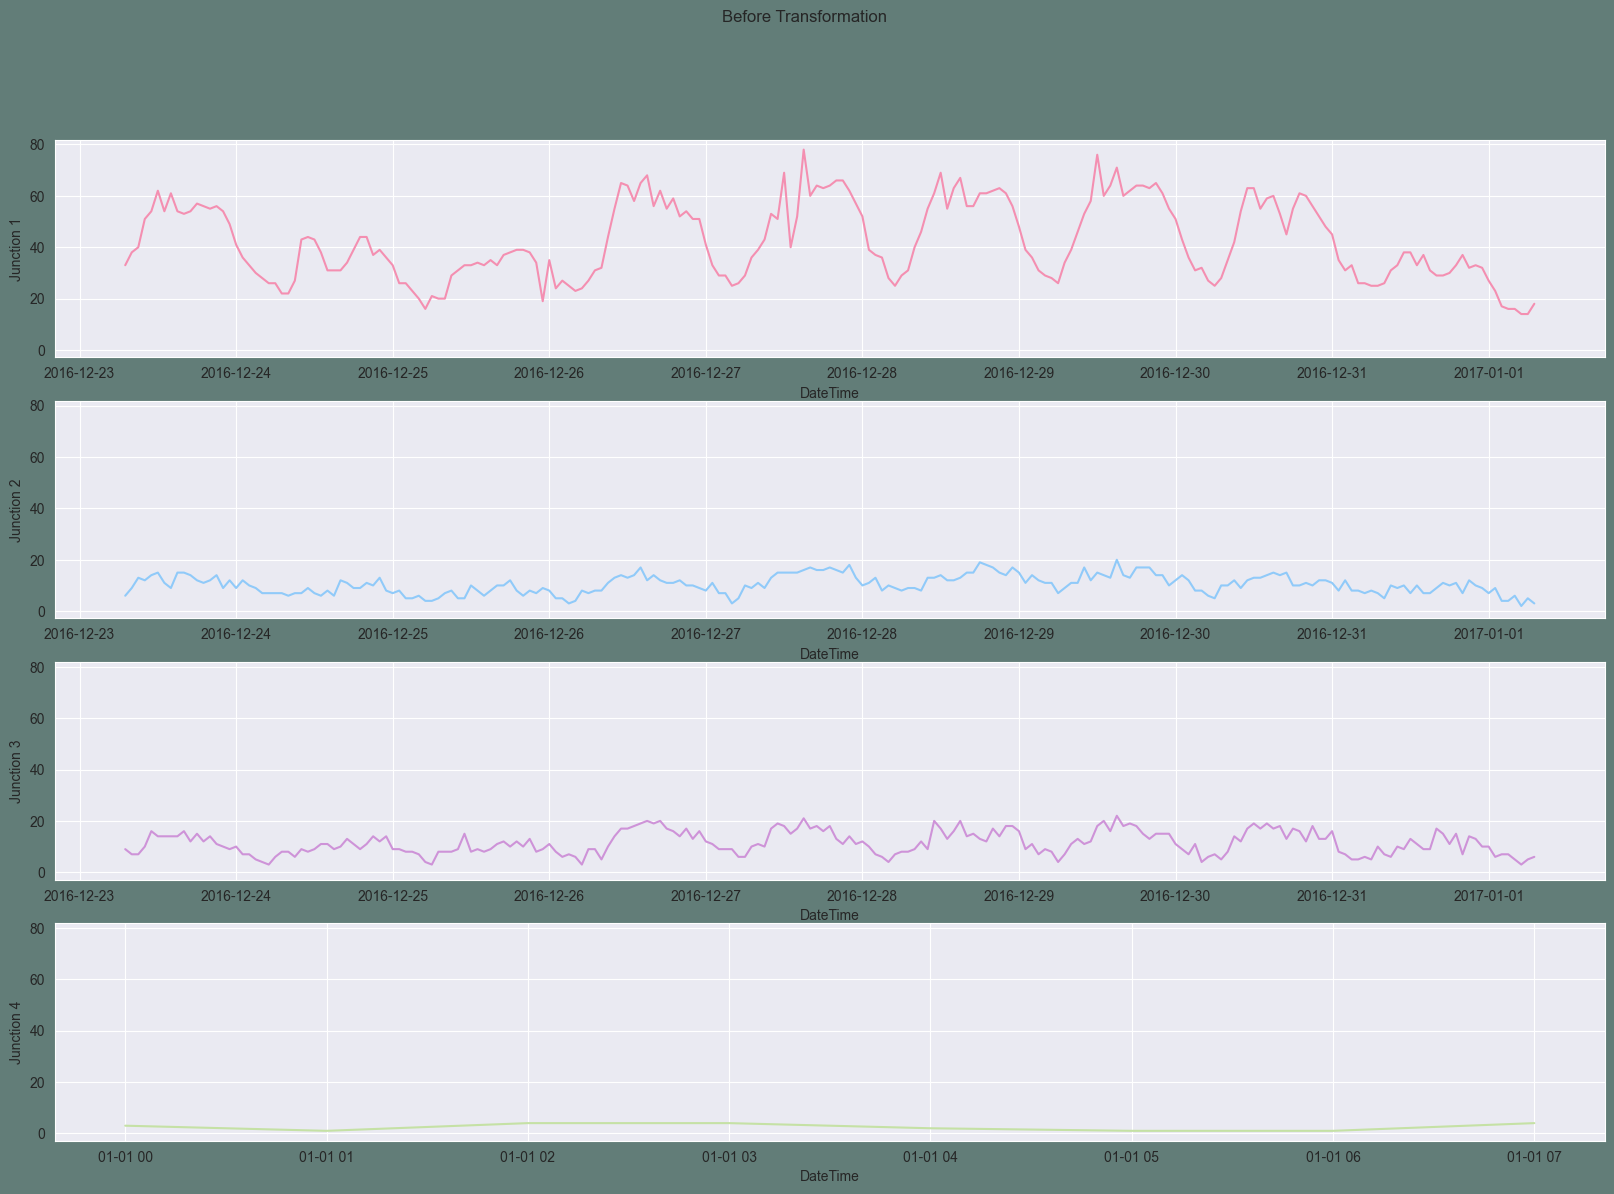

In [124]:
sub_plots(
    df_junction_1.Vehicles, df_junction_2.Vehicles, df_junction_3.Vehicles, df_junction_4.Vehicles, "Before Transformation",
    start_date='2016-12-23 07:00:00', end_date='2017-01-01 07:00:00'
)

In [125]:
df_junction_2

,Vehicles
DateTime,
2015-11-01 00:00:00,6.0
2015-11-01 01:00:00,6.0
2015-11-01 02:00:00,5.0
2015-11-01 03:00:00,6.0
2015-11-01 04:00:00,7.0
...,...
2017-06-30 19:00:00,34.0
2017-06-30 20:00:00,35.0
2017-06-30 21:00:00,31.0


Steps for Transforming: Normalizing - Differencing

The Normalize function is used to standardize the data, while the Difference function is used to make the time series stationary or to extract seasonality patterns.

In [126]:
# Normalize Function
def normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

Differencing to eliminate the seasonality should be performed as follows:

For Junction one, I will be taking a difference of weekly values.
For junction two, The difference of consecutive days is a better choice
For Junctions three and four, the difference of the hourly values will serve the purpose.

In [127]:
#Normalizing and Differencing to make the series stationary 
df_normalized_1, av_J1, std_J1 = normalize(df_junction_1, "Vehicles")
diff_1 = difference(df_normalized_1, col="Vehicles", interval=(24*7)) #taking a week's difference
df_normalized_1 = df_normalized_1[24*7:]
df_junction_1 = df_junction_1[24*7:]
df_normalized_1.columns = ["Norm"]
df_normalized_1["Diff"]= diff_1
print(df_normalized_1.head())

df_normalized_2, av_J2, std_J2 = normalize(df_junction_2, "Vehicles")
diff_2 = difference(df_normalized_2, col="Vehicles", interval=(24)) #taking a day's difference
df_normalized_2 = df_normalized_2[24:]
df_junction_2 = df_junction_2[24:]
df_normalized_2.columns = ["Norm"]
df_normalized_2["Diff"]= diff_2

df_normalized_3, av_J3, std_J3 = normalize(df_junction_3, "Vehicles")
diff_3 = difference(df_normalized_3, col="Vehicles", interval=1) #taking an hour's difference
df_normalized_3 = df_normalized_3[1:]
df_junction_3 = df_junction_3[1:]
df_normalized_3.columns = ["Norm"]
df_normalized_3["Diff"]= diff_3

df_normalized_4, av_J4, std_J4 = normalize(df_junction_4, "Vehicles")
diff_4 = difference(df_normalized_4, col="Vehicles", interval=1) #taking an hour's difference
df_normalized_4 = df_normalized_4[1:]
df_junction_4 = df_junction_4[1:]
df_normalized_4.columns = ["Norm"]
df_normalized_4["Diff"]= diff_4

df_normalized_2, df_junction_2

                         Norm      Diff
DateTime                               
2015-11-08 00:00:00 -1.397089 -0.087356
2015-11-08 01:00:00 -1.266055  0.131035
2015-11-08 02:00:00 -1.484446  0.043678
2015-11-08 03:00:00 -1.615481  0.043678
2015-11-08 04:00:00 -1.528124  0.043678


(                         Norm      Diff
 DateTime                               
 2015-11-02 00:00:00 -0.845120  0.271060
 2015-11-02 01:00:00 -1.116180  0.000000
 2015-11-02 02:00:00 -0.845120  0.406589
 2015-11-02 03:00:00 -1.251709 -0.135530
 2015-11-02 04:00:00 -1.522769 -0.542119
 ...                       ...       ...
 2017-06-30 19:00:00  2.678655 -0.948709
 2017-06-30 20:00:00  2.814185 -0.677649
 2017-06-30 21:00:00  2.272065 -0.271060
 2017-06-30 22:00:00  2.001006 -0.406589
 2017-06-30 23:00:00  1.729946 -1.219768
 
 [14568 rows x 2 columns],
                      Vehicles
 DateTime                     
 2015-11-02 00:00:00       8.0
 2015-11-02 01:00:00       6.0
 2015-11-02 02:00:00       8.0
 2015-11-02 03:00:00       5.0
 2015-11-02 04:00:00       3.0
 ...                       ...
 2017-06-30 19:00:00      34.0
 2017-06-30 20:00:00      35.0
 2017-06-30 21:00:00      31.0
 2017-06-30 22:00:00      29.0
 2017-06-30 23:00:00      27.0
 
 [14568 rows x 1 columns])

In [128]:
df_junction_2

,Vehicles
DateTime,
2015-11-02 00:00:00,8.0
2015-11-02 01:00:00,6.0
2015-11-02 02:00:00,8.0
2015-11-02 03:00:00,5.0
2015-11-02 04:00:00,3.0
...,...
2017-06-30 19:00:00,34.0
2017-06-30 20:00:00,35.0
2017-06-30 21:00:00,31.0


The difference method calculates the differences between two consecutive observations. This can help stabilize the time series. Differences are often used to infer the trend and seasonality patterns of the time series.

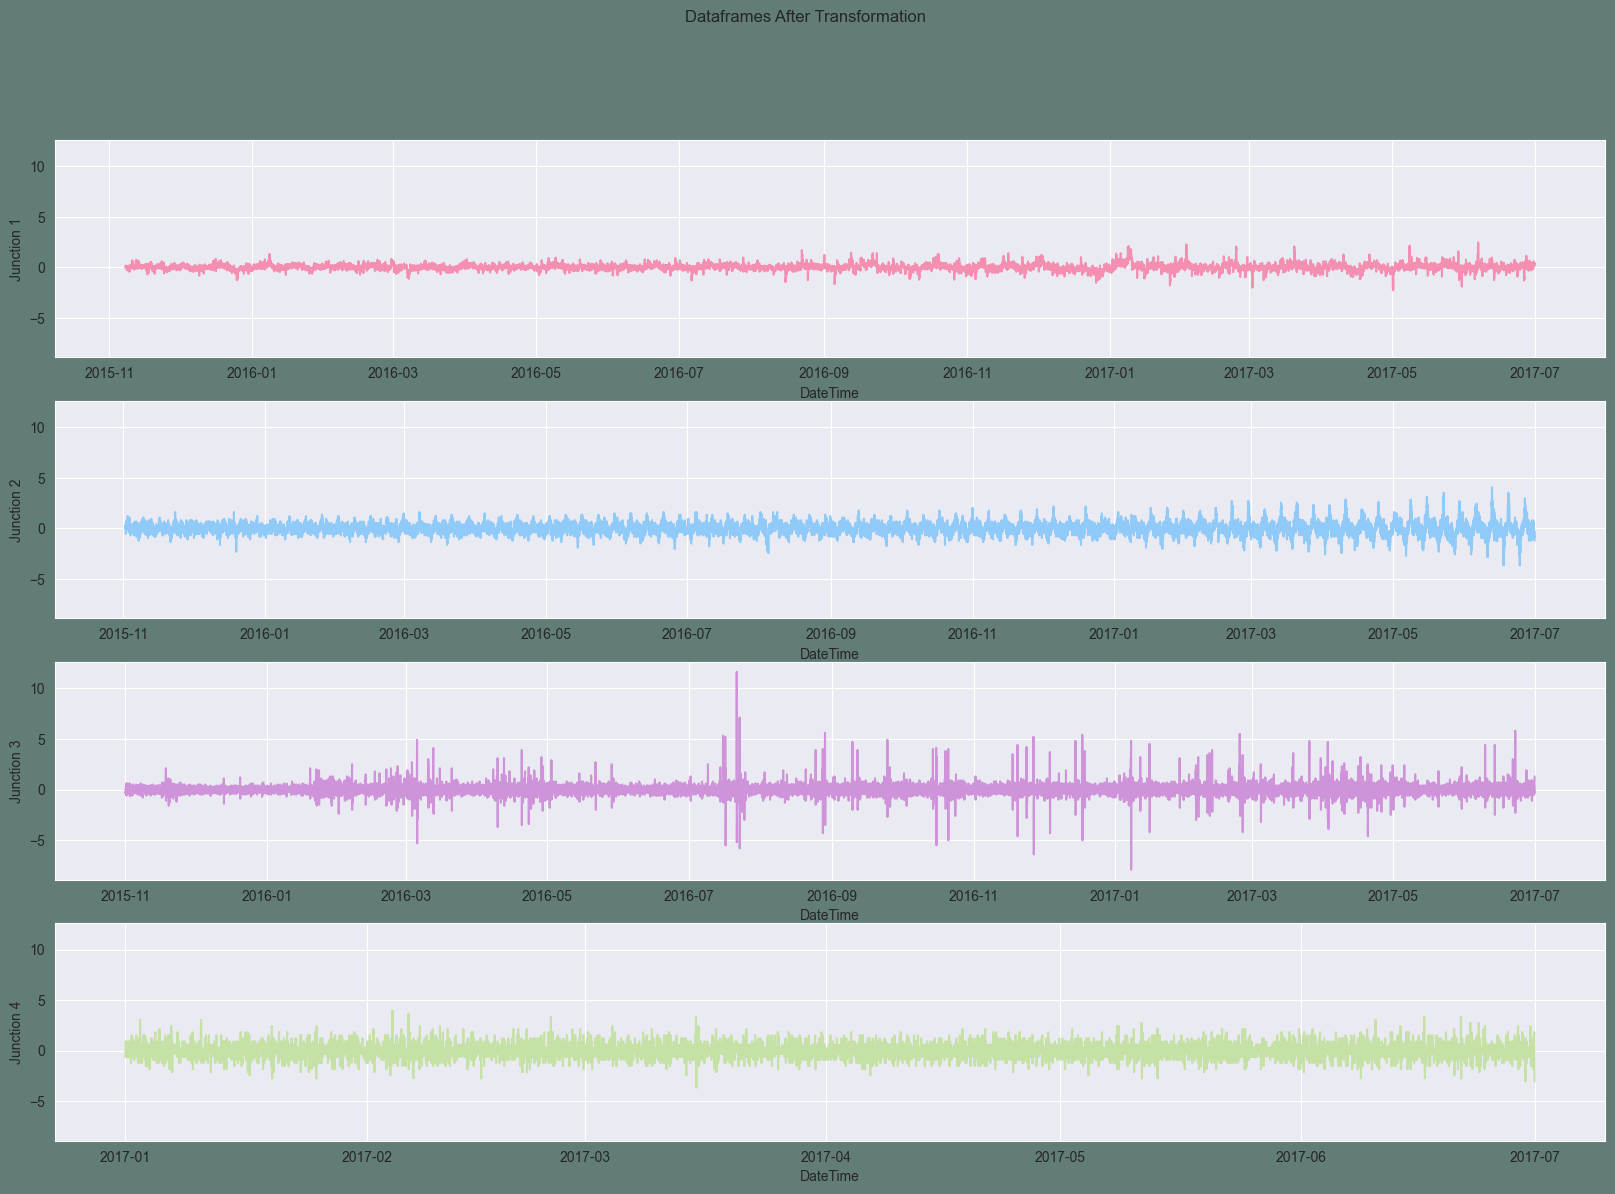

In [129]:
sub_plots(df_normalized_1.Diff, df_normalized_2.Diff, df_normalized_3.Diff, df_normalized_4.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test.

In [130]:
def check_stationary(df_all_junctions):
    check = adfuller(df_all_junctions.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

list_df_normalized = [ df_normalized_1["Diff"], df_normalized_2["Diff"], df_normalized_3["Diff"], df_normalized_4["Diff"]] 
for i in list_df_normalized:
    print("\n")
    check_stationary(i)


ADF Statistic: -14.560310817810494
p-value: 4.8064342852760346e-27
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary

ADF Statistic: -21.955176060947327
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary

ADF Statistic: -27.83788632695625
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.6275258176488
p-value: 3.812335652192037e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


The ADF test is used to test the stationarity of the time series. The test results show that the p-value is lower than a certain threshold value (usually 0.05) and the ADF statistic is lower compared to the critical values. Therefore, we can conclude that the time series is stationary and contains no obvious trends or structures over time. This means that the time series becomes more suitable for statistical analysis and forecasting.

Now data is stationary, preprocessing the data for the neural net by:

Splitting the test train sets
Assigning X as features and y as target
Reshaping data for neural net

In [131]:
df_junction_2

,Vehicles
DateTime,
2015-11-02 00:00:00,8.0
2015-11-02 01:00:00,6.0
2015-11-02 02:00:00,8.0
2015-11-02 03:00:00,5.0
2015-11-02 04:00:00,3.0
...,...
2017-06-30 19:00:00,34.0
2017-06-30 20:00:00,35.0
2017-06-30 21:00:00,31.0


In [132]:
#Differencing created some NA values as we took a weeks data into consideration while differencing
df_junction_1_not_normalized = df_junction_1.copy()
df_junction_1 = df_normalized_1["Diff"].dropna()  #dropping null values
df_junction_1 = df_junction_1.to_frame()

df_junction_2_not_normalized = df_junction_2.copy()
df_junction_2 = df_normalized_2["Diff"].dropna()
df_junction_2 = df_junction_2.to_frame()

df_junction_3_not_normalized = df_junction_3.copy()
df_junction_3 = df_normalized_3["Diff"].dropna()
df_junction_3 = df_junction_3.to_frame()

df_junction_4_not_normalized = df_junction_4.copy()
df_junction_4 = df_normalized_4["Diff"].dropna()
df_junction_4 = df_junction_4.to_frame()


df_junction_2_not_normalized

,Vehicles
DateTime,
2015-11-02 00:00:00,8.0
2015-11-02 01:00:00,6.0
2015-11-02 02:00:00,8.0
2015-11-02 03:00:00,5.0
2015-11-02 04:00:00,3.0
...,...
2017-06-30 19:00:00,34.0
2017-06-30 20:00:00,35.0
2017-06-30 21:00:00,31.0


Differencing Process (Differencing): While preparing the data for time series analysis, firstly, the differentiation process was applied. Differentiation makes the time series structure in the data more stable and makes the data stationary. However, some NaN values may have occurred as a result of the difference process. These code blocks reduce these NaN values to achieve a stationary time series.

In [133]:
df_junction_1

,Diff
DateTime,
2015-11-08 00:00:00,-0.087356
2015-11-08 01:00:00,0.131035
2015-11-08 02:00:00,0.043678
2015-11-08 03:00:00,0.043678
2015-11-08 04:00:00,0.043678
...,...
2017-06-30 19:00:00,0.480460
2017-06-30 20:00:00,0.262069
2017-06-30 21:00:00,0.393104


In [134]:
#Splitting the dataset
def split_data(df):
    training_size = int(len(df)*0.85)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

#Splitting the training and test datasets 
junction_1_train, junction_1_test = split_data(df_junction_1)
junction_2_train, junction_2_test = split_data(df_junction_2)
junction_3_train, junction_3_test = split_data(df_junction_3)
junction_4_train, junction_4_test = split_data(df_junction_4)

Separating Data into Training and Test Sets: Some of the data is reserved for training and some for testing. These codes divide the data into training and test sets in a specified ratio. Usually 85% can be divided into training and 15% testing, but these rates can be changed.

In [135]:
#Target and Feature - lagging the data: We are using the previous 'steps' time periods to predict the next time period.
def target_and_feature(df):
    end_len = len(df)
    X = []
    y = []
    steps = 24
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

Separating Data as Features and Target Variables: Features and target variables are separated. These codes prepare the data necessary to predict the target variable for the next time period using the previous time slots (32 pieces). The features are derived from these previous time periods.

In [136]:
#fixing the shape of X_test and X_train
def feature_fix_shape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

Correcting the Shape of Features: Since deep learning model training will be done, the input data (X_train and X_test) is brought into a suitable shape (shape). The shape of the features is made compatible with models such as RNN (Recurrent Neural Network) or LSTM (Long Short-Term Memory).

In [137]:
# Assigning features and target 
X_train_junction_1, y_train_junction_1 = target_and_feature(junction_1_train)
X_test_junction_1, y_test_junction_1 = target_and_feature(junction_1_test)
X_train_junction_1, X_test_junction_1 = feature_fix_shape(X_train_junction_1, X_test_junction_1)

X_train_junction_2, y_train_junction_2 = target_and_feature(junction_2_train)
X_test_junction_2, y_test_junction_2 = target_and_feature(junction_2_test)
X_train_junction_2, X_test_junction_2 = feature_fix_shape(X_train_junction_2, X_test_junction_2)

X_train_junction_3, y_train_junction_3 = target_and_feature(junction_3_train)
X_test_junction_3, y_test_junction_3 = target_and_feature(junction_3_test)
X_train_junction_3, X_test_junction_3 = feature_fix_shape(X_train_junction_3, X_test_junction_3)

X_train_junction_4, y_train_junction_4 = target_and_feature(junction_4_train)
X_test_junction_4, y_test_junction_4 = target_and_feature(junction_4_test)
X_train_junction_4, X_test_junction_4 = feature_fix_shape(X_train_junction_4, X_test_junction_4)

## Model

I have settled to use LSTM. In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions.

In [138]:
X_train_junction_1.shape[1], X_train_junction_1.shape[2]

(24, 1)

The Dropout method used to reduce the overfitting of LSTM (Long Short Term Memory) or other neural network models disables random units with a certain probability (usually with values as low as 0.2 or 0.5) during each learning period. This makes it difficult for the model to learn different learning paths and features and helps to obtain a more generalized model.

return_sequences=True is used when you want to preserve the output of an LSTM layer for all time steps, while return_sequences=False is used when you want to preserve the output from the last time step only.

In [139]:

def lstm_model(X_train, y_train, X_test, y_test): # Model for the prediction
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) # early stopping to prevent overfitting

    # The LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Learning rate and momentum settings
    model.compile(optimizer=optimizer, loss='mean_squared_error') 
    model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=50, batch_size=120, callbacks=[early_stopping], shuffle=False)
    pred_lmts = model.predict(X_test)
    return pred_lmts



def rmse_value(test, predicted): # To calculate the root mean squared error in predictions
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


def predictions_plot(test, predicted, m): # To plot the comparative plot of targets and predictions
    plt.figure(figsize=(12, 5), facecolor="#627D78")
    plt.plot(test, color=colors[m], label="True Value", alpha=0.5)
    plt.plot(predicted, color="#627D78", label="Predicted Values")
    plt.title("LSTM Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

## Fit the model

Now, I will be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets.


Fitting the junction 1 and plotting the predictions and test set

In [140]:
pred_junction_1 = lstm_model(X_train_junction_1,y_train_junction_1,X_test_junction_1, y_test_junction_1) # #Predictions For Junction 1 

Epoch 1/50
102/102 [==============================] - 23s 182ms/step - loss: 0.0825 - val_loss: 0.1108
Epoch 2/50
102/102 [==============================] - 17s 166ms/step - loss: 0.0733 - val_loss: 0.1106
Epoch 3/50
102/102 [==============================] - 18s 172ms/step - loss: 0.0721 - val_loss: 0.1101
Epoch 4/50
102/102 [==============================] - 18s 172ms/step - loss: 0.0717 - val_loss: 0.1096
Epoch 5/50
102/102 [==============================] - 18s 173ms/step - loss: 0.0711 - val_loss: 0.1091
Epoch 6/50
102/102 [==============================] - 18s 173ms/step - loss: 0.0706 - val_loss: 0.1089
Epoch 7/50
102/102 [==============================] - 18s 176ms/step - loss: 0.0699 - val_loss: 0.1083
Epoch 8/50
102/102 [==============================] - 18s 176ms/step - loss: 0.0692 - val_loss: 0.1082
Epoch 9/50
102/102 [==============================] - 18s 173ms/step - loss: 0.0691 - val_loss: 0.1084
Epoch 10/50
102/102 [==============================] - 18s 172ms/step - l

The root mean squared error is 0.28014576203577246.


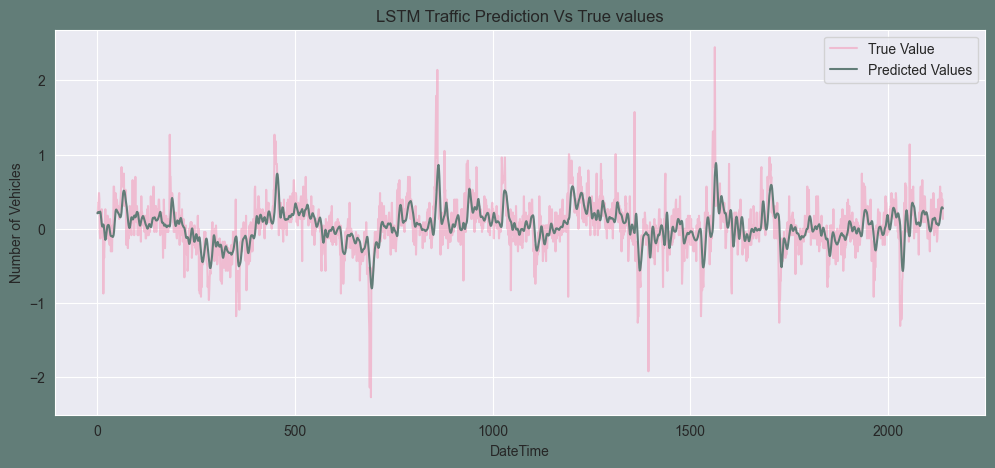

In [141]:
rmse_junction_1 = rmse_value(y_test_junction_1, pred_junction_1) # Results for J1 
predictions_plot(y_test_junction_1, pred_junction_1, 0)

Fitting the junction 2 and plotting the predictions and test set

In [142]:
pred_junction_2 = lstm_model(X_train_junction_2,y_train_junction_2,X_test_junction_2, y_test_junction_2) #Predictions For Junction 2. 

Epoch 1/50
103/103 [==============================] - 20s 165ms/step - loss: 0.2658 - val_loss: 0.6920
Epoch 2/50
103/103 [==============================] - 17s 166ms/step - loss: 0.2490 - val_loss: 0.6252
Epoch 3/50
103/103 [==============================] - 17s 164ms/step - loss: 0.2216 - val_loss: 0.5632
Epoch 4/50
103/103 [==============================] - 17s 167ms/step - loss: 0.2117 - val_loss: 0.5417
Epoch 5/50
103/103 [==============================] - 17s 168ms/step - loss: 0.2076 - val_loss: 0.5307
Epoch 6/50
103/103 [==============================] - 18s 171ms/step - loss: 0.2043 - val_loss: 0.5201
Epoch 7/50
103/103 [==============================] - 18s 172ms/step - loss: 0.2029 - val_loss: 0.4960
Epoch 8/50
103/103 [==============================] - 18s 173ms/step - loss: 0.1996 - val_loss: 0.4996
Epoch 9/50
103/103 [==============================] - 18s 176ms/step - loss: 0.1994 - val_loss: 0.4915
Epoch 10/50
103/103 [==============================] - 18s 172ms/step - l

The root mean squared error is 0.5727931801476824.


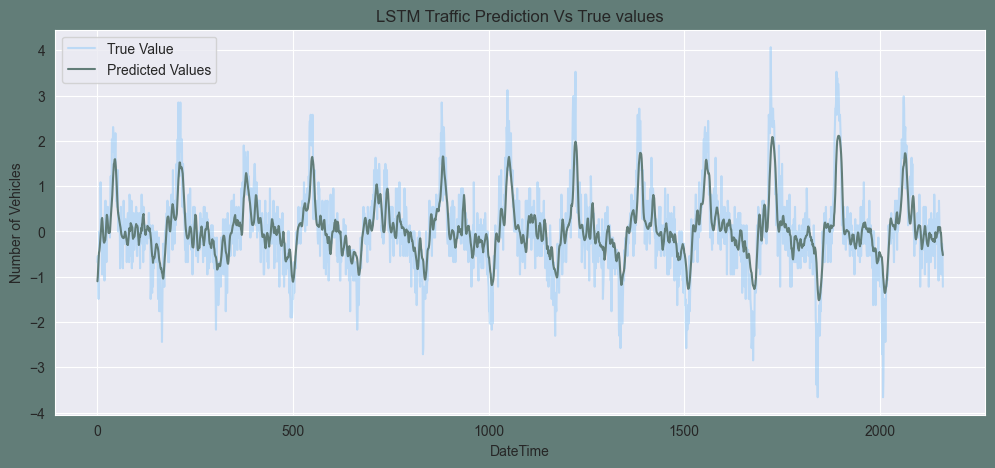

In [143]:
rmse_junction_2 = rmse_value(y_test_junction_2, pred_junction_2) # Results for J2
predictions_plot(y_test_junction_2, pred_junction_2, 1)

Fitting the junction 3 and plotting the predictions and test set

In [144]:
pred_junction_3 = lstm_model(X_train_junction_3,y_train_junction_3,X_test_junction_3, y_test_junction_3) #Predictions For Junction 3.

Epoch 1/50
104/104 [==============================] - 24s 194ms/step - loss: 0.2968 - val_loss: 0.3326
Epoch 2/50
104/104 [==============================] - 19s 187ms/step - loss: 0.2968 - val_loss: 0.3328
Epoch 3/50
104/104 [==============================] - 20s 188ms/step - loss: 0.2959 - val_loss: 0.3311
Epoch 4/50
104/104 [==============================] - 20s 191ms/step - loss: 0.2948 - val_loss: 0.3331
Epoch 5/50
104/104 [==============================] - 20s 192ms/step - loss: 0.2951 - val_loss: 0.3286
Epoch 6/50
104/104 [==============================] - 20s 193ms/step - loss: 0.2941 - val_loss: 0.3319
Epoch 7/50
104/104 [==============================] - 20s 195ms/step - loss: 0.2925 - val_loss: 0.3230
Epoch 8/50
104/104 [==============================] - 20s 195ms/step - loss: 0.2903 - val_loss: 0.3169
Epoch 9/50
104/104 [==============================] - 20s 196ms/step - loss: 0.2871 - val_loss: 0.3118
Epoch 10/50
104/104 [==============================] - 21s 198ms/step - l

The root mean squared error is 0.5512080304176687.


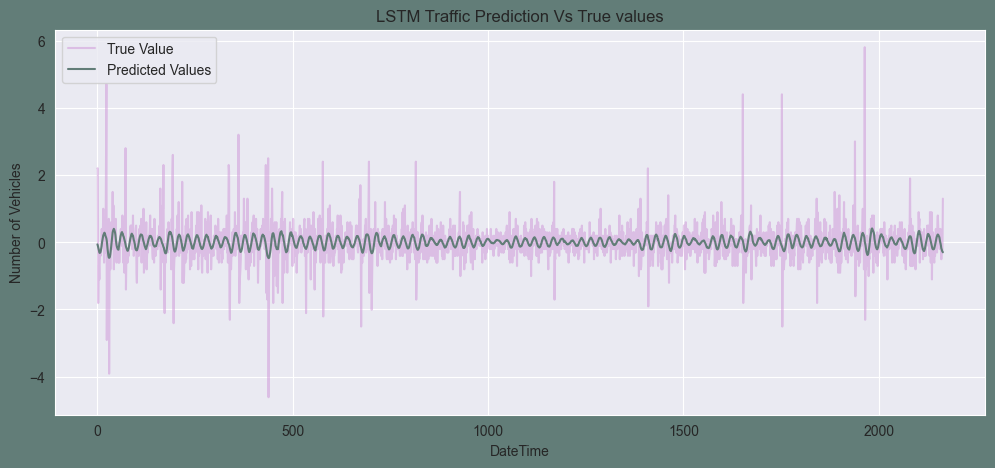

In [145]:
rmse_junction_3 = rmse_value(y_test_junction_3, pred_junction_3) # Results for J3
predictions_plot(y_test_junction_3, pred_junction_3, 2)

Fitting the junction 4 and plotting the predictions and test set

In [146]:
pred_junction_4 = lstm_model(X_train_junction_4,y_train_junction_4,X_test_junction_4, y_test_junction_4) #Predictions For Junction 4.

Epoch 1/50
31/31 [==============================] - 11s 238ms/step - loss: 0.7174 - val_loss: 0.9331
Epoch 2/50
31/31 [==============================] - 6s 206ms/step - loss: 0.7191 - val_loss: 0.9353
Epoch 3/50
31/31 [==============================] - 6s 206ms/step - loss: 0.7209 - val_loss: 0.9298
Epoch 4/50
31/31 [==============================] - 7s 210ms/step - loss: 0.7180 - val_loss: 0.9303
Epoch 5/50
31/31 [==============================] - 6s 206ms/step - loss: 0.7180 - val_loss: 0.9398
Epoch 6/50
31/31 [==============================] - 6s 204ms/step - loss: 0.7232 - val_loss: 0.9365
Epoch 7/50
31/31 [==============================] - 6s 210ms/step - loss: 0.7194 - val_loss: 0.9309
Epoch 8/50
31/31 [==============================] - 6s 203ms/step - loss: 0.7189 - val_loss: 0.9304
Epoch 9/50
31/31 [==============================] - 6s 203ms/step - loss: 0.7164 - val_loss: 0.9295
Epoch 10/50
31/31 [==============================] - 6s 205ms/step - loss: 0.7182 - val_loss: 0.927

The root mean squared error is 0.944372695147245.


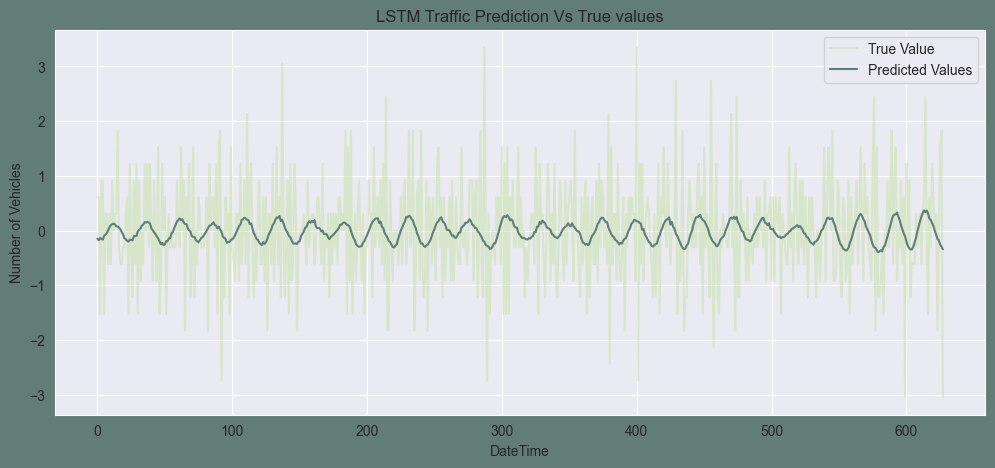

In [147]:
rmse_junction_4 = rmse_value(y_test_junction_4, pred_junction_4) # Results for J4
predictions_plot(y_test_junction_4, pred_junction_4, 3)

## Inversing The Transformation Of Data

I will be inversing transforms that I applied to the datasets to remove the seasonality and trends. Performing this step will make the predictions get back on the accurate scale.



# Functions to inverse transforms and Plot comparitive plots

In [148]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2 = sns.lineplot(ax=axes[1], data=df_2["Vehicles"], color="#627D78")
    axes[1].set(ylabel ="Original")

The inverse transform on the junction 1

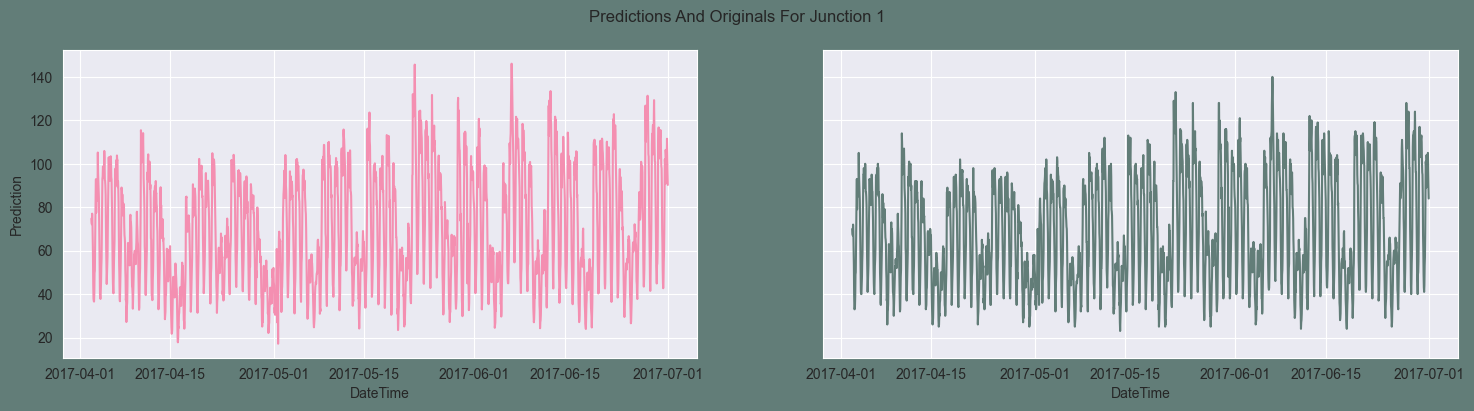

In [149]:
# invert the differenced forecast for Junction 1 
recover_1 = df_normalized_1.Norm[-2141:-1].to_frame()
recover_1["Pred"]= pred_junction_1
transform_reversed_junction_1 = inverse_difference(recover_1.Norm, recover_1.Pred).to_frame()
transform_reversed_junction_1.columns = ["Pred_Normed"]
#Invert the normalization Junction 1
final_junction_1_pred = (transform_reversed_junction_1.values* std_J1) + av_J1
transform_reversed_junction_1["Pred_Final"] = final_junction_1_pred
#Plotting the Predictions with orignals 
sub_plots_2(transform_reversed_junction_1["Pred_Final"], df_junction_1_not_normalized[-2141:-1],"Predictions And Originals For Junction 1", 0)

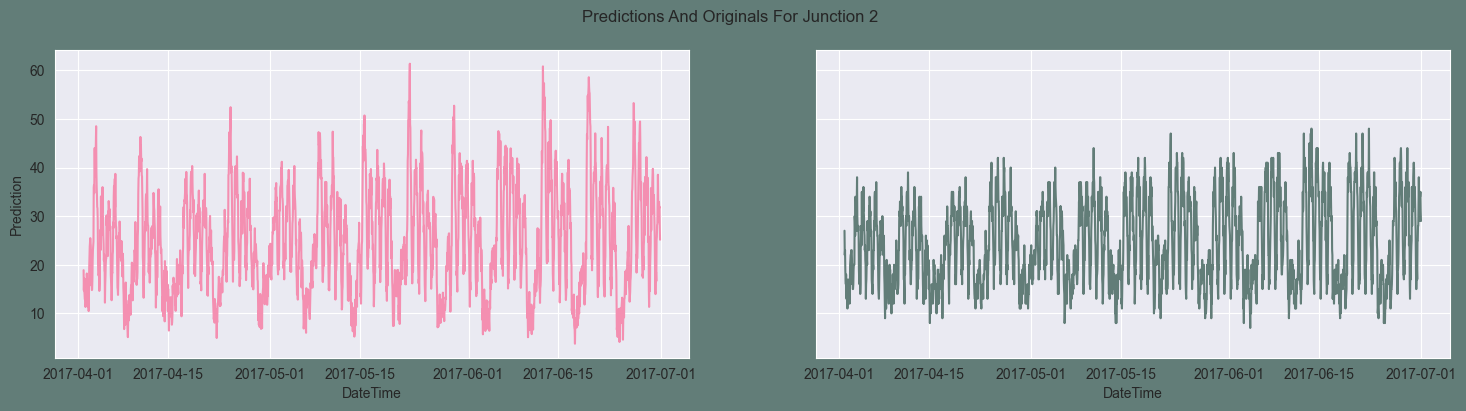

In [150]:
# invert the differenced forecast for Junction 2 
recover_2 = df_normalized_2.Norm[-2163:-1].to_frame()
recover_2["Pred"]= pred_junction_2
transform_reversed_junction_2 = inverse_difference(recover_2.Norm, recover_2.Pred).to_frame()
transform_reversed_junction_2.columns = ["Pred_Normed"]
#Invert the normalization Junction 2
final_junction_2_pred = (transform_reversed_junction_2.values* std_J2) + av_J2
transform_reversed_junction_2["Pred_Final"] = final_junction_2_pred
#Plotting the Predictions with originals 
sub_plots_2(transform_reversed_junction_2["Pred_Final"], df_junction_2_not_normalized[-2163:-1],"Predictions And Originals For Junction 2", 0)

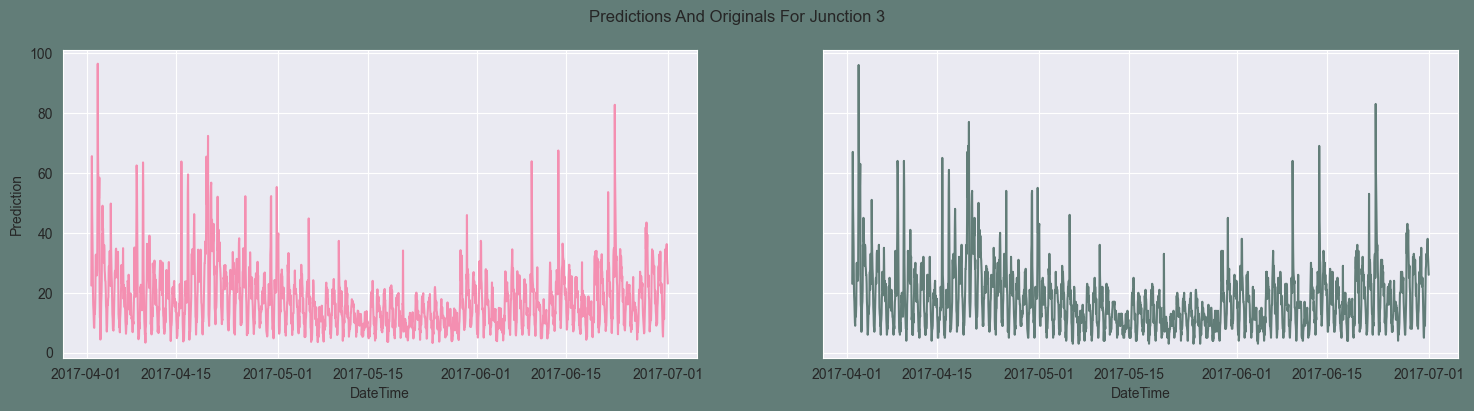

In [151]:
# invert the differenced forecast for Junction 3 
recover_3 = df_normalized_3.Norm[-2166:-1].to_frame()
recover_3["Pred"]= pred_junction_3
transform_reversed_junction_3 = inverse_difference(recover_3.Norm, recover_3.Pred).to_frame()
transform_reversed_junction_3.columns = ["Pred_Normed"]
#Invert the normalization Junction 3
final_junction_3_pred = (transform_reversed_junction_3.values* std_J3) + av_J3
transform_reversed_junction_3["Pred_Final"] = final_junction_3_pred
#Plotting the Predictions with originals 
sub_plots_2(transform_reversed_junction_3["Pred_Final"], df_junction_3_not_normalized[-2166:-1],"Predictions And Originals For Junction 3", 0)

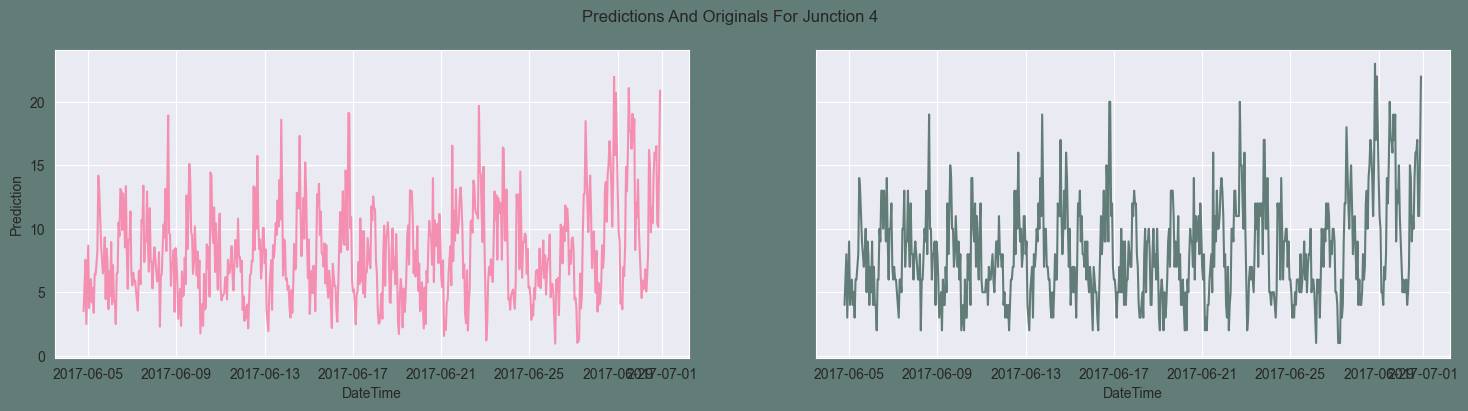

In [152]:
# invert the differenced forecast for Junction 4 
recover_4 = df_normalized_4.Norm[-629:-1].to_frame()
recover_4["Pred"]= pred_junction_4
transform_reversed_junction_4 = inverse_difference(recover_4.Norm, recover_4.Pred).to_frame()
transform_reversed_junction_4.columns = ["Pred_Normed"]
#Invert the normalization Junction 4
final_junction_4_pred = (transform_reversed_junction_4.values* std_J4) + av_J4
transform_reversed_junction_4["Pred_Final"] = final_junction_4_pred
#Plotting the Predictions with originals 
sub_plots_2(transform_reversed_junction_4["Pred_Final"], df_junction_4_not_normalized[-629:-1],"Predictions And Originals For Junction 4", 0)

In [153]:
combined_df_junction_1 = pd.concat([transform_reversed_junction_1["Pred_Final"], df_junction_1_not_normalized[-2141:-1]], axis=1)
combined_df_junction_1.columns = ["Pred", "Original"]
combined_df_junction_1

,Pred,Original
DateTime,,
2017-04-02 19:00:00,74.755965,70.0
2017-04-02 20:00:00,73.029028,68.0
2017-04-02 21:00:00,72.125177,67.0
2017-04-02 22:00:00,77.028165,72.0
2017-04-02 23:00:00,73.891479,69.0
...,...,...
2017-06-30 18:00:00,101.095655,95.0
2017-06-30 19:00:00,111.522739,105.0
2017-06-30 20:00:00,102.623861,96.0


In [154]:
combined_df_junction_2 = pd.concat([transform_reversed_junction_2["Pred_Final"], df_junction_2_not_normalized[-2163:-1]], axis=1)
combined_df_junction_2.columns = ["Pred", "Original"]
combined_df_junction_2

,Pred,Original
DateTime,,
2017-04-01 21:00:00,18.884962,27.0
2017-04-01 22:00:00,14.725818,22.0
2017-04-01 23:00:00,17.250786,23.0
2017-04-02 00:00:00,14.412390,19.0
2017-04-02 01:00:00,13.532375,17.0
...,...,...
2017-06-30 18:00:00,32.934740,34.0
2017-06-30 19:00:00,31.663656,34.0
2017-06-30 20:00:00,31.948969,35.0


In [155]:
combined_df_junction_3 = pd.concat([transform_reversed_junction_3["Pred_Final"], df_junction_3_not_normalized[-2166:-1]], axis=1)
combined_df_junction_3.columns = ["Pred", "Original"]
combined_df_junction_3

,Pred,Original
DateTime,,
2017-04-01 18:00:00,22.415777,23.0
2017-04-01 19:00:00,44.050256,45.0
2017-04-01 20:00:00,65.571088,67.0
2017-04-01 21:00:00,47.074458,49.0
2017-04-01 22:00:00,39.492730,42.0
...,...,...
2017-06-30 18:00:00,36.223119,38.0
2017-06-30 19:00:00,30.914548,33.0
2017-06-30 20:00:00,28.475568,31.0


In [156]:
combined_df_junction_4 = pd.concat([transform_reversed_junction_4["Pred_Final"], df_junction_4_not_normalized[-629:-1]], axis=1)
combined_df_junction_4.columns = ["Pred", "Original"]
combined_df_junction_4

,Pred,Original
DateTime,,
2017-06-04 19:00:00,3.515364,4.0
2017-06-04 20:00:00,5.420594,6.0
2017-06-04 21:00:00,7.556456,8.0
2017-06-04 22:00:00,2.501036,3.0
2017-06-04 23:00:00,5.450287,6.0
...,...,...
2017-06-30 18:00:00,16.504623,17.0
2017-06-30 19:00:00,10.412022,11.0
2017-06-30 20:00:00,10.157320,11.0
